In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Bayesian Information Criteria (BIC)

The galaxies dataset. 

In [2]:
!wget http://www.key2stats.com/Velocities_for_82_Galaxies_1152_58.csv -O galaxy.csv --no-check-certificate

--2021-05-24 11:56:45--  http://www.key2stats.com/Velocities_for_82_Galaxies_1152_58.csv
Resolving www.key2stats.com (www.key2stats.com)... 52.207.128.24
Connecting to www.key2stats.com (www.key2stats.com)|52.207.128.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1221 (1,2K) [application/csv]
Saving to: ‘galaxy.csv’

galaxy.csv          100%[===================>]   1,19K  --.-KB/s    in 0,004s  

2021-05-24 11:56:46 (321 KB/s) - ‘galaxy.csv’ saved [1221/1221]



In [3]:
# Read dataset - galaxies
galaxy = pd.read_csv('galaxy.csv')
galaxy.pop('Unnamed: 0')
galaxy.pop('X')
# Checking dataframe
print("The shape of the dataset is: {}".format(galaxy.shape))
galaxy.head()

The shape of the dataset is: (82, 1)


,dat
0,9172
1,9350
2,9483
3,9558
4,9775


This data set is contained in the package mass which comes to standard with R and contains the velocities of 82 galaxies that come from six well-separated conic sections of the Corona borealis region of the sky. When we fitted this model before, both in the case of using EM algorithms
and in the case of using MCMC algorithms, we selected the number of components K to be exactly equal to six. That selection came from the fact that well, we knew that the data was collected from
six well separated conic sections so it made sense in that context to use that number of components.
Now, what we want to do today in this example is to use the BIC the Bayesian information criteria to
verify that that choice is actually supported by the data that we have at hand. 

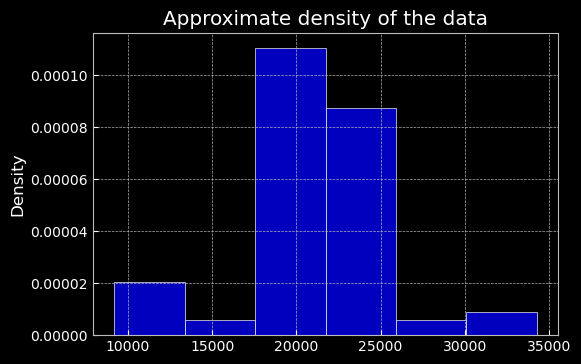

In [4]:
from scipy.stats import norm

## Clear the environment and load required libraries
np.random.seed(1)

### Loading data and setting up global variables
x          = galaxy['dat'].to_numpy() # Data
n          = len(x)
KKmax      = 20       # Components used to compute BIC. From 2 to 20
BIC        = np.zeros(KKmax)

sns.histplot(x, stat= 'density', bins = 6)
plt.title('Approximate density of the data')
plt.show()

In [5]:
# Initializing constants
w_sum = []
mu_sum = []
sigma_sum = []

### MLE EM algorithm

Computing EM with 2 components
Computing EM with 3 components
Computing EM with 4 components
Computing EM with 5 components
Computing EM with 6 components
Computing EM with 7 components
Computing EM with 8 components
Computing EM with 9 components
Computing EM with 10 components
Computing EM with 11 components
Computing EM with 12 components
Computing EM with 13 components
Computing EM with 14 components
Computing EM with 15 components
Computing EM with 16 components
Computing EM with 17 components
Computing EM with 18 components
Computing EM with 19 components
Computing EM with 20 components


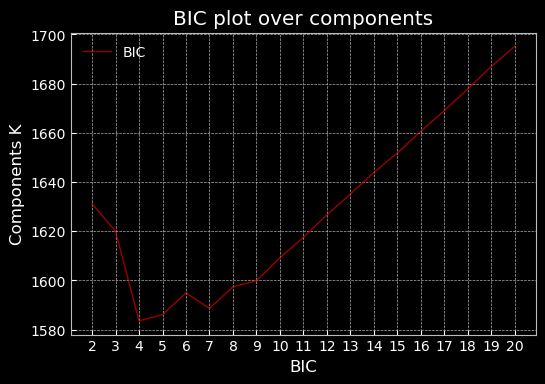

In [6]:
from scipy.stats import lognorm


for KK in range(2, KKmax + 1):
  print('Computing EM with {} components'.format(KK))

  ## Initialize the parameters
  w     = np.ones(KK) / KK # Assign equal weight to each component to start with
  mu    = norm.rvs(loc = np.mean(x), scale = np.std(x), size = KK, random_state = 1) # Random cluster centers randomly spread over the support of the data
  sigma = np.std(x) / KK                  # Initial standard deviation 

  s  = 0     # Counter of the current iteration
  sw = False # Decide when the algorithm will end
  KL = np.NINF  # Value of Q to monitor convergence
  KL_out = []
  epsilon = 10e-6  # Stopping criteria

  ## Checking convergence of the algorithm
  while(not sw):
    ## Expectation (E) step
    v = np.zeros((n, KK))
    for k in range(KK):
      v[:, k] = np.log(w[k]) + norm.logpdf(loc = mu[k], scale = sigma, x = x)
    for i in range(n):
      v[i, :] = np.exp(v[i, :] - max(v[i, : ])) / np.sum(np.exp(v[i, :] - max(v[i, :])))  # Go from logs to actual weights in a numerically stable manner
    
    ## Maximization (M) step
    # Weights
    w = np.mean(v, axis = 0)
    # Mus
    mu = np.zeros(KK)
    for k in range(KK):
      for i in range(n):
        # Update Mu
        mu[k] = mu[k] + (v[i,k] * x[i])
      mu[k] = mu[k] / np.sum(v[:, k])

    # Standard deviations
    sigma = 0
    for i in range(n):
      for k in range(KK):
        sigma = sigma + (v[i,k] * ((x[i] - mu[k])**2))
    sigma = np.sqrt(sigma / np.sum(v))

    ##Check convergence
    KLn = 0 # Value of Q function at current iteration
    for i in range(n):
      for k in range(k):
        KLn = KLn + v[i, k]*(np.log(w[k]) + norm.logpdf(loc = mu[k], scale =sigma, x = x[i]))
    
    # If relative error is less than epsilon stop
    if(np.abs(KLn - KL) / np.abs(KLn) < epsilon):
      sw = True

    KL = KLn
    KL_out.append(KL)
    s = s + 1

  w_sum.append(w)
  mu_sum.append(mu)
  sigma_sum.append(sigma)
  
  # Computing BIC
  for i in range(n):
    BIC[KK - 1] = BIC[KK - 1] - 2 * np.log(np.sum(w * norm.pdf(loc = mu, scale = sigma, x = x[i])))
  BIC[KK - 1] = BIC[KK - 1] + ((KK - 1) + 1 + KK) * np.log(n)  ### KK-1 independent weights, one variance, and KK means

## Plot the BIC with different components
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(2, KKmax + 1), BIC[1:], 'r-', lw=1, alpha=0.6, label='BIC') # BIC plot
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('BIC plot over components')
plt.xlabel('BIC')
plt.ylabel('Components K')
plt.xticks(np.arange(2, KKmax + 1))
plt.show()

It is possible to see that for small values of K, so for values around two, three, the BIC is relatively large. Then, as you start adding components to the mixture, BIC decreases. We can see that actually the optimal, so the minimum value of the BIC does coincide with K equal to seven which is great, that means that this confirms what we had expected or at least something very similar (Galaxies = 6). Then, as you add more components to the mixture  because now, you have more complexity but you are not necessarily explaining the data better, the value of the BIC starts to increase. You can see that this is not a strictly monotone, you have some local modes in a couple of places. But you can overall see that the global minimum is clearly located at K equal to 7. 

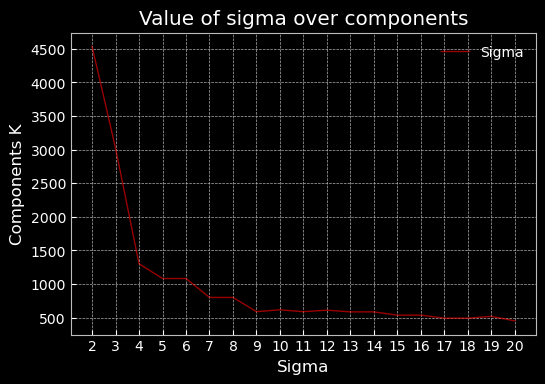

In [7]:
## What happens with the variance (bandwidth) as K increases
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(2, KKmax + 1), sigma_sum[:], 'r-', lw=1, alpha=0.6, label='Sigma') # BIC plot
ax.legend(loc='best', frameon=False)
# Arrangind data
plt.title('Value of sigma over components')
plt.xlabel('Sigma')
plt.ylabel('Components K')
plt.xticks(np.arange(2, KKmax + 1))
plt.show()

We discussed that the value of sigma is related, in some sense, with the number or there is a trade-off between the value of sigma and the number of components in the mixture. In particular, as you use more components, those tend to be more localized and therefore, the value of sigma becomes smaller. That is, in some sense, the intuition that we get by comparing kernel density estimation with mixture models. 

In [8]:
## Method to compute density estimates for various values of K
def compute_density(xx, w, mu, sigma):
    KK  = len(w)
    nxx = len(xx)
    density_EM = np.zeros(nxx)
    for s in range(nxx):
        for k in range(KK):
            density_EM[s] = density_EM[s] +  w[k] * norm.pdf(loc = mu[k], scale = sigma, x = xx[s])
    return density_EM

In [9]:
# Estimating densities
xx = np.linspace(5000, 37000, num = 300)
KK = 8
mdeKK8 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])
KK = 7
mdeKK7 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])
KK = 6
mdeKK6 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])
KK = 5
mdeKK5 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])
KK = 4
mdeKK4 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])
KK = 3
mdeKK3 = compute_density(xx, w_sum[KK - 2], mu_sum[KK - 2], sigma_sum[KK - 2])

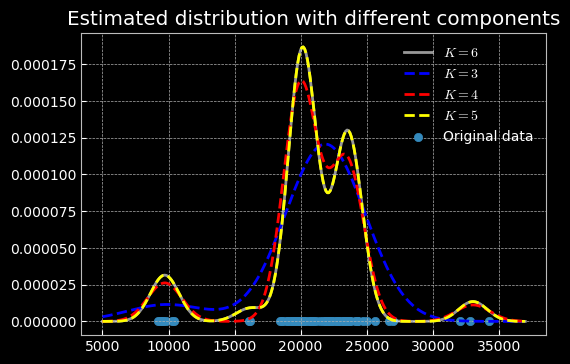

In [10]:
## Plot the final result distribution for various samples
fig, ax = plt.subplots(1, 1)
# Bayesian plot (K = 6)
ax.plot(xx, mdeKK6, color = 'white',  lw=2, alpha=0.6, label='$K = 6$') # Trace plot of data
# EM algorithm K = 3
ax.plot(xx, mdeKK3, '--', color = 'blue', label = '$K = 3$')
# EM algorithm K = 4
ax.plot(xx, mdeKK4, '--', color = 'red', label = '$K = 4$')
# EM algorithm K = 7
ax.plot(xx, mdeKK5, '--', color = 'yellow', label = '$K = 5$')
# Plotting original data
ax.scatter(np.array(x), np.zeros((x.shape[0])), label = 'Original data')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Estimated distribution with different components')
plt.show()

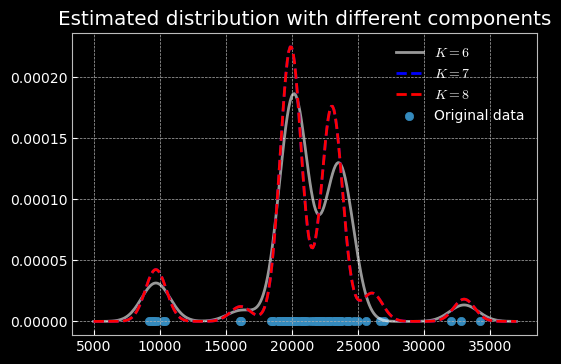

In [11]:
 ## Comparing density estimates for K = 6, 7 and 8
 ## Plot the final result distribution for various samples
fig, ax = plt.subplots(1, 1)
# Bayesian plot (K = 6)
ax.plot(xx, mdeKK6, color = 'white',  lw=2, alpha=0.6, label='$K = 6$') # Trace plot of data
# EM algorithm K = 7
ax.plot(xx, mdeKK7, '--', color = 'blue', label = '$K = 7$')
# EM algorithm K = 8
ax.plot(xx, mdeKK8, '--', color = 'red', label = '$K = 8$')
# Plotting original data
ax.scatter(np.array(x), np.zeros((x.shape[0])), label = 'Original data')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Estimated distribution with different components')
plt.show()